# Machine Vision<br>Assignment 3 - Binary image analysis

## Personal details

* **Name(s):** ``
* **Student ID(s):** ``

## 1. Introduction

In this assignment, you will need to implement a simple segmentation method. Given an image of a jigsaw puzzle (Figure 1), your goal is to separate the puzzle pieces from the background. In the simplest case, this can be achieved by choosing a global threshold that separates the dark and light pixels. However, we also need to perform some preprocessing and postprocessing steps to get satisfactory segmentation results. 
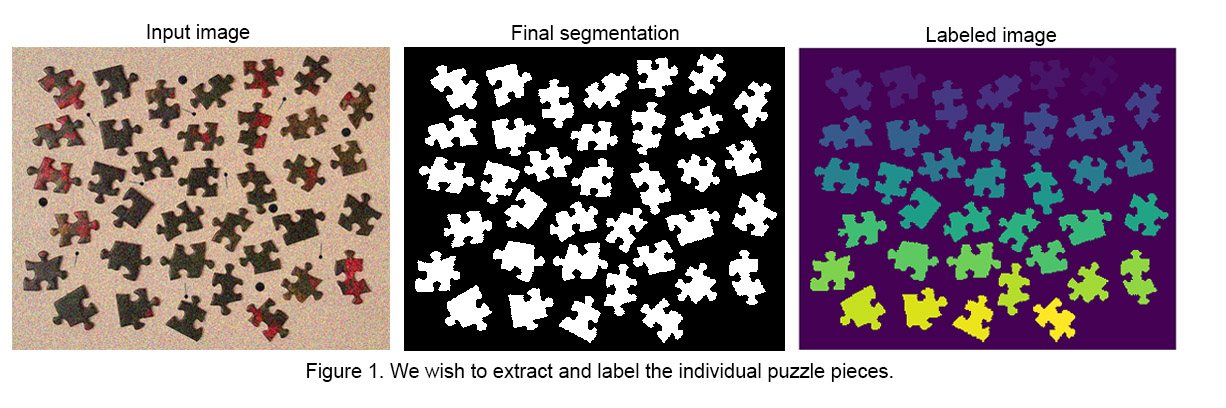

Let us start by displaying the test image and the corresponding grayscale histogram.

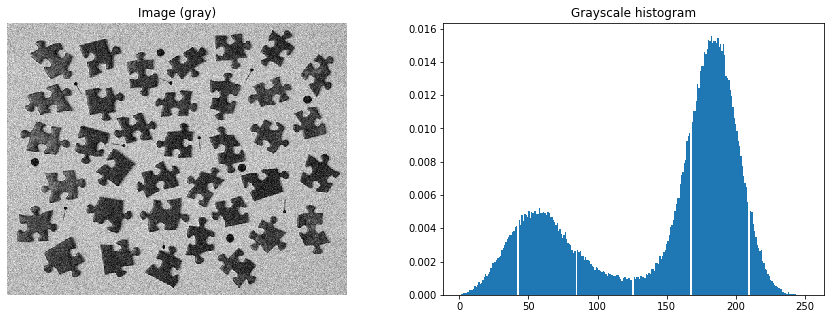

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('images/puzzle.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Image (gray)')
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Grayscale histogram')
h = plt.hist(gray.ravel(),256, density=True)

## 2. Preprocessing

Notice that the image is quite noisy. This will make the segmentation more challenging. Before we continue with the segmentation, we want reduce the effect of the noise. We will use the bilateral filter as it has property of preserving edges and details.

**2.1. Noise reduction** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. Denoise the image `puzzle.jpg` (gray) with a bilateral filter. Show the filtered image and the corresponding grayscale histogram in the same figure. You can use the OpenCV function __[`bilateralFilter()`](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=medianblur#bilateralfilter)__. The sample code __[`Binary.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Binary.ipynb)__ shows you how to use this function. Experiment with different filter sizes and sigma values. Choose the parameters that you think work best.

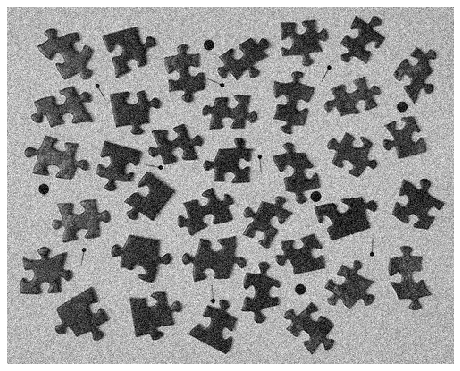

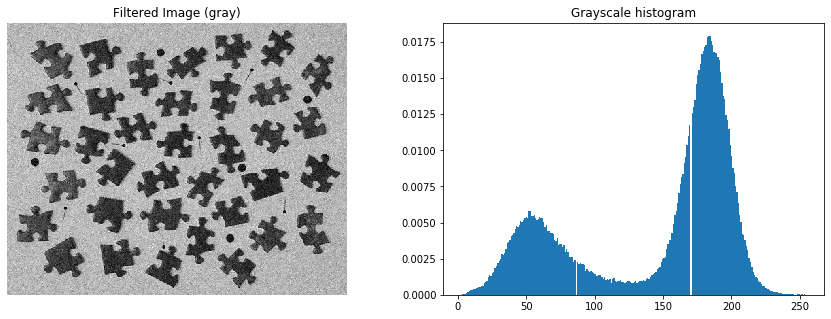

In [2]:
# ---------- YOUR CODE STARTS HERE -----------

noisy = (gray+np.random.standard_normal(gray.shape)*10).clip(0,255).astype(np.uint8)
plt.figure(figsize=(8,8))
plt.imshow(noisy, cmap='gray')
plt.axis('off')

filtered = cv2.bilateralFilter(noisy,9,12,12)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Filtered Image (gray)')
plt.imshow(filtered, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title('Grayscale histogram')
h = plt.hist(filtered.ravel(),256, density=True)

# ---------- YOUR CODE ENDS HERE -----------

## 3. Segmentation

Now that you have filtered the image, you can continue with the segmentation. A pixel should be classified as foreground if its intensity is less than the threshold value. The challenging part is to choose a good threshold value.

**3.1. How can you use the histogram when choosing the threshold?** $\quad$ <font color=red>(0.25 points)</font>

`From the histogram we find that the gray scale is mainly composed of two peaks. We want to reduce the impact of the critical portion on image segmentation by selecting the appropriate threshold.Threshold in histogram is the trough between the two peaks.`

**3.2. Threshold the image** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. You should segment the filtered image and display the result. Choose the threshold based on the histogram you plotted earlier. After that, you can use the OpenCV function __[`threshold()`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#threshold)__. Again, you may find the sample code __[`Binary.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Binary.ipynb)__ useful.

(-0.5, 499.5, 399.5, -0.5)

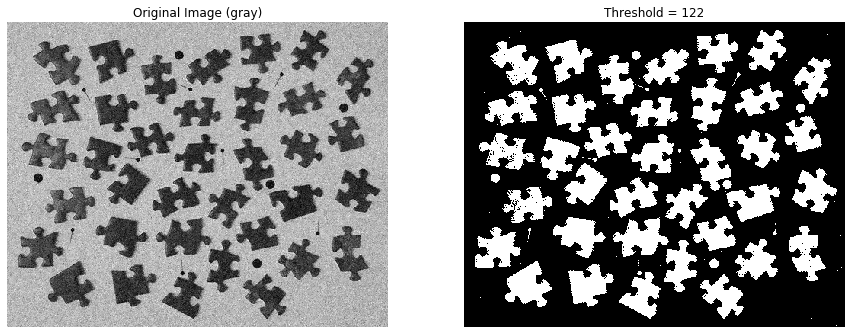

In [3]:
# ---------- YOUR CODE STARTS HERE -----------

thre = 122
ret,thresh = cv2.threshold(filtered,thre,255,cv2.THRESH_BINARY_INV)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(filtered, cmap='gray')
plt.title('Original Image (gray)')
plt.axis('off')
plt.subplot(122)
plt.imshow(thresh, cmap='gray')
plt.title("Threshold = %d" %thre)
plt.axis('off')


# ---------- YOUR CODE ENDS HERE -----------

**3.3. Introduction to Otsu's method**

In the previous task, you chose the threshold manually. Otsu's method aims to do this automatically by looking at the histogram. Its goal is to select a threshold $t$ that minimizes the within-group variance defined as

$$
\sigma_w^2(t) = q_1(t) \sigma_1^2(t) + q_2(t) \sigma_2^2(t). \qquad (1)
$$

Let us see how the algorithm works. The following code cell computes $\sigma_w^2(t)$ for a single threshold value $t=75$. Run the code and observe the plotted histogram. The histogram has been split into two groups according to the threshold (red line). For both groups, we first compute the sum of histogram values

$$
q_1(t) = \sum_{i=1}^{t} P(i) \qquad q_2(t) = \sum_{i=t+1}^{I} P(i), \qquad (2)
$$

where the histogram probabilities of the gray values are denoted by $P(i)$. We also need to compute the mean values of the two distributions

$$
\mu_1(t) = \sum_{i=1}^{t} \frac{i P(i)}{q_1(t)}  \qquad \mu_2(t) = \sum_{i=t+1}^{I} \frac{i P(i)}{q_2(t)}. \qquad (3)
$$

In the plotted figure, the values $\mu_1$ and $\mu_2$ are indicated by the vertical lines (cyan and pink). Now we can compute variances

$$
\sigma_1^2(t) = \sum_{i=1}^{t} [i - \mu_1(t)]^2 \frac{P(i)}{q_1(t)}  \qquad \sigma_2^2(t) = \sum_{i=t+1}^{I} [i - \mu_2(t)]^2 \frac{P(i)}{q_2(t)}. \qquad (4)
$$

In practise, we compute $\sigma_w^2(t)$ for all possible $t$ values and choose the threshold that gives the smallest within-group variance.

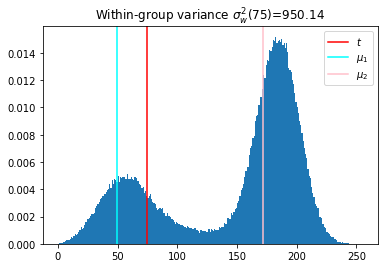

In [4]:
# Threshold (arbitrarily chosen for this test)
t = 75

# Intensities are in range [0,255]
bins = np.arange(0,256,1)

# Note that 'gray' is the original (noisy) image
P = plt.hist(gray.ravel(),bins,density=True)[0]

# Compute q1 and q2 for a given threshold (Eq. 2)
q1 = np.sum(P[:t])
q2 = np.sum(P[t:])

# Mean values (Eq. 3)
i1 = np.arange(0,t,1)
i2 = np.arange(t,255,1)
mean1 = np.sum(i1*P[:t])/q1
mean2 = np.sum(i2*P[t:])/q2

# Variances (Eq. 4)
var1 = np.sum(((i1 - mean1)**2)*P[:t])/q1
var2 = np.sum(((i2 - mean2)**2)*P[t:])/q2

# Weighted within-group variance (Eq. 1)
varw = q1*var1 + q2*var2

# Plot vertical lines
h1 = plt.axvline(x=t,color='red')
h2 = plt.axvline(x=mean1,color='cyan')
h3 = plt.axvline(x=mean2,color='pink')
plt.title('Within-group variance $\sigma_w^2(%d)$=%.2f' %(t,varw))
plt.legend((h1, h2, h3), ('$t$', '$\mu_1$', '$\mu_2$'));

**3.4. Implement Otsu's method** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. You need to implement Otsu's method by following the instructions (and code) shown above. You should print the obtained threshold. After that, segment the filtered image and display the result. Compare your result to OpenCV's implementation of Otsu's method (code is given below). Your method should output the same threshold ($\pm$ 1 difference is also fine). Notice that you only need a few extra lines of code since you can reuse the code given above. You may notice that some of the calculations are unnecessary.

122


D:\Anaconda\envs\mv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda\envs\mv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


(-0.5, 499.5, 399.5, -0.5)

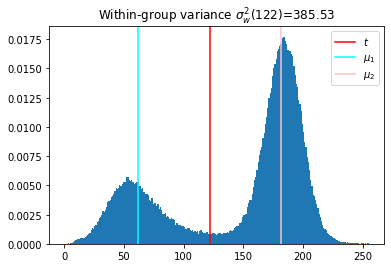

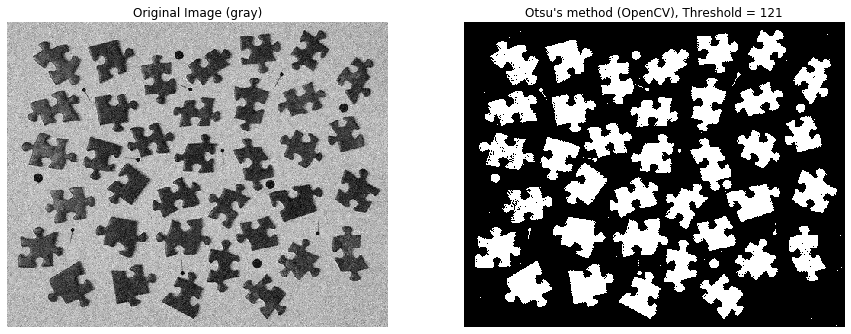

In [5]:
# ---------- YOUR CODE STARTS HERE -----------

# Implement Otsu's method
minvarw = 10000


# Note that 'gray' has been replaced by 'filtered'
P = plt.hist(filtered.ravel(),bins,density=True)[0]

# Threshold 
for t in range(0,255):

    # Compute q1 and q2 for a given threshold (Eq. 2)
    q1 = np.sum(P[:t])
    q2 = np.sum(P[t:])

    # Mean values (Eq. 3)
    i1 = np.arange(0,t,1)
    i2 = np.arange(t,255,1)
    mean1 = np.sum(i1*P[:t])/q1
    mean2 = np.sum(i2*P[t:])/q2

    # Variances (Eq. 4)
    var1 = np.sum(((i1 - mean1)**2)*P[:t])/q1
    var2 = np.sum(((i2 - mean2)**2)*P[t:])/q2

    # Weighted within-group variance (Eq. 1)
    varw = q1*var1 + q2*var2
    
    if varw < minvarw:
        minvarw = varw
        optionalt = t
        opmean1 = mean1
        opmean2 = mean2

print(optionalt)

# Plot vertical lines
h1 = plt.axvline(x=optionalt,color='red')
h2 = plt.axvline(x=opmean1,color='cyan')
h3 = plt.axvline(x=opmean2,color='pink')
plt.title('Within-group variance $\sigma_w^2(%d)$=%.2f' %(optionalt,minvarw))
plt.legend((h1, h2, h3), ('$t$', '$\mu_1$', '$\mu_2$'));


# Compare to OpenCV's implementation. Notice that 'gray' is the original 
# image. You should change the input to the filtered image when comparing.
ret, otsu = cv2.threshold(filtered,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(filtered, cmap='gray')
plt.title('Original Image (gray)')
plt.axis('off')
plt.subplot(122)
plt.imshow(otsu, cmap='gray')
plt.title("Otsu's method (OpenCV), Threshold = %d" %ret)
plt.axis('off')

# ---------- YOUR CODE ENDS HERE -----------


*Hints:*

- Avoid division by zero (you will get a warning or an error).
- Feel free to experiment with alternative ways to implement the algorithm.

## 4. Post-processing

At this point, the segmentation result should look pretty good. A closer inspection reveals that there are small holes, noise and unwanted objects in the segmentation. Next, we will further improve the segmentation result.

**4.1. Morphological operations** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. Use morphological closing to fill the small holes. You can freely choose the shape and size of the structuring element. See the example in __[`Binary.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Binary.ipynb)__. Then, remove small objects (noise) using morphological opening. Do not worry if you are not able to remove all unwanted objects. We will take care of those in the next section. **Note!** Do not use too large structuring element as you do not want to destroy the shape of the puzzle pieces by oversmoothing.

(-0.5, 499.5, 399.5, -0.5)

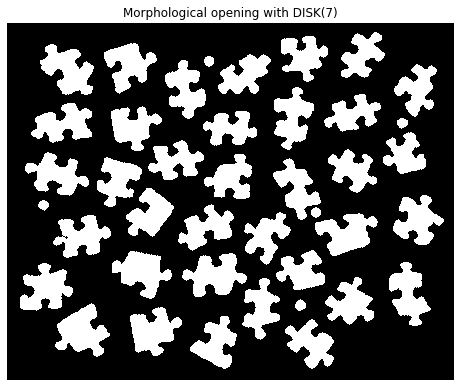

In [6]:
# ---------- YOUR CODE STARTS HERE -----------
seg = otsu

sel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
closing = cv2.morphologyEx(seg, cv2.MORPH_CLOSE, sel1)
sel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, sel2)
plt.figure(figsize=(8,8))
plt.imshow(opening, cmap='gray')
plt.title('Morphological opening with DISK(7)')
plt.axis('off')


# ---------- YOUR CODE ENDS HERE -----------

**4.2. Connected component labeling**

The following code gives an unique label to each connected component in the binary image. It also extracts the contours of the objects. You should change the input image `otsu` to the image you got from the previous step. Notice that we still have more objects than we have puzzle pieces.

(-8.650000000000002, 511.65, 405.8, -7.800000000000001)

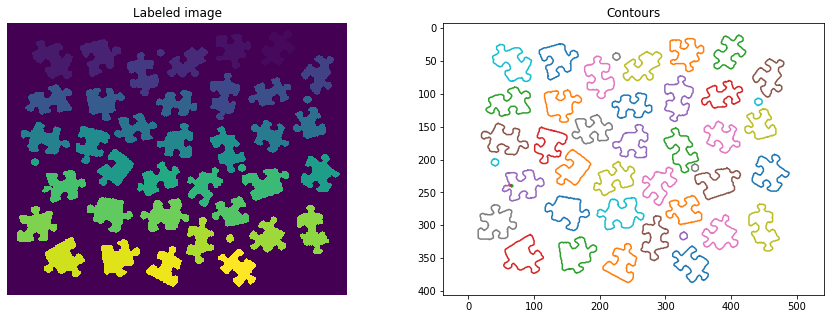

In [7]:
ret, labels = cv2.connectedComponents(opening)
cnt,_ = cv2.findContours(opening, 1, 1)


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(labels)
plt.title('Labeled image')
plt.axis('off')
plt.subplot(122)
for i in range(len(cnt)):
    plt.plot(cnt[i][:,0,0],cnt[i][:,0,1])
plt.gca().invert_yaxis()
plt.title('Contours')
plt.axis('equal')


**4.3. Remove small ojects** $\quad$ <font color=red>(0.50 points)</font>

As a final step, we want to remove those unwanted round objects. Luckily, they are much smaller than the puzzle pieces. Complete the following code cell. Compute the area of each contour __[`contourArea()`](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#contourarea)__ and keep objects, which area is more than 500. After that, perform the Step 4.2. again. The final segmentation should be similar to the one in Figure 1. In the end, there should be 36 objects in total (each piece represents one object).

(-8.650000000000002, 511.65, 405.8, -7.800000000000001)

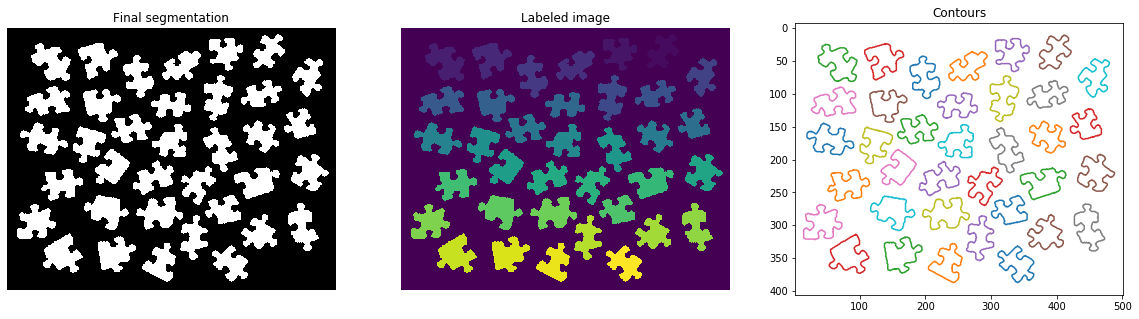

In [8]:
# This will be the final result (binary image)
final = np.zeros_like(otsu)
cntnew = []

# ---------- YOUR CODE STARTS HERE -----------
for i in range(len(cnt)):
    if cv2.contourArea(cnt[i]) > 500:
        cntnew.append(cnt[i])
        
for i in range(len(cntnew)):
    cv2.drawContours(final, cntnew, i, 255, thickness=-1)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(final, cmap='gray')
plt.title('Final segmentation')
plt.axis('off')

# Here is Step 4.2. again.

ret, labels = cv2.connectedComponents(final)
cnt2,_ = cv2.findContours(final, 1, 1)

plt.subplot(132)
plt.imshow(labels)
plt.title('Labeled image')
plt.axis('off')
plt.subplot(133)
for i in range(len(cnt2)):
    plt.plot(cnt2[i][:,0,0],cnt2[i][:,0,1])
plt.gca().invert_yaxis()
plt.title('Contours')
plt.axis('equal')

# print(np.size(cnt2)) 


# ---------- YOUR CODE ENDS HERE -----------

**Hint:**

- You can use __[`drawContours()`](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html#drawcontours)__ to draw the contours of objects, which are large enough. For example: `cv2.drawContours(final, cnt, i, 255, thickness=-1)`, where the parameter `thickness=-1` defines that the contours should be filled.

## 5.1. More advanced methods

Our test image was relatively easy to segment. This was mainly because the background was much brighter compared to the puzzle pieces. If the background was different color, the segmentation might not work anymore. In such case, one could utilize the color-based segmentation method from the previous assignment. If the puzzle pieces were touching each other it would cause another challenge. We might be able to separate the pieces from the background. However, the individual pieces would be difficult to extract (connected component labeling) as the segmented regions might be overlapping. The __[`watershed()`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#watershed)__ algorithm is a classical method that is often used to segment overlapping objects. Furthermore, OpenCV also offers __[`grabCut()`](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#grabcut)__ segmentation method, which is based on graph cuts.

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`3.5 hours.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`None.`

# References
`https://github.com/jtheikkila/mvis/blob/master/jupyter/Binary.ipynb`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A3.ipynb` file) into **`MV_A3_[student number(s)].zip`** (e.g. `MV_A3_1234567.zip` if solo work or `MV_A3_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A3_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 3.2.2019**